<a href="https://colab.research.google.com/github/Aravinda89/Pytorch-Tutorial/blob/main/CPU_to_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CPU to GPU

In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(device)


cuda


In [5]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw




Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw




Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw




Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [7]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)
    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x

model = FMNIST()

In [8]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [18]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 1

for i in range(num_epochs):
    cum_loss = 0
    
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        cum_loss += loss.item()
     
    print(f"Training loss: {cum_loss/len(trainloader)}")

Training loss: 0.5529591971114755


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(testloader))

test_image_id = 0 
img = images[test_image_id].view(1, 784) 

model.to('cpu')
with torch.no_grad():
    logps = model(img)

In [12]:
ps = torch.exp(logps)
ps

tensor([[8.5421e-06, 5.0097e-06, 2.1269e-04, 2.8388e-05, 5.5525e-04, 3.5757e-01,
         9.5089e-05, 2.7186e-01, 1.4557e-02, 3.5511e-01]])

In [13]:
nps = ps.numpy()[0]
nps

array([8.5421252e-06, 5.0097124e-06, 2.1268730e-04, 2.8387934e-05,
       5.5524748e-04, 3.5756749e-01, 9.5088624e-05, 2.7186221e-01,
       1.4556721e-02, 3.5510865e-01], dtype=float32)

<BarContainer object of 10 artists>

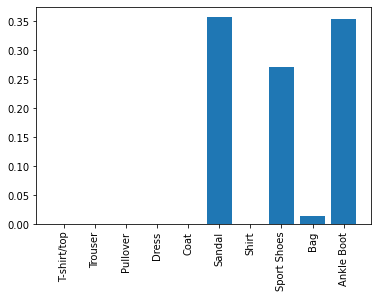

In [14]:
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoes','Bag','Ankle Boot']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

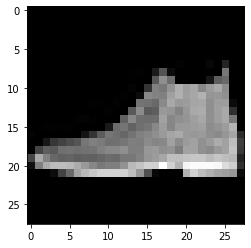

In [15]:
def denormalize(tensor):
  tensor = tensor*0.5 + 0.5
  return tensor
  
img = img.view(28,-1)
img = denormalize(img)
plt.imshow(img,cmap='gray')

In [16]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)